In [1]:
import pandas as pd
import numpy as np
import h5py

In [2]:
# create a hp5y file
f = h5py.File('data/test.h5', 'w')
# create random 5x20 matrix of 0 1 or 2
data = np.random.randint(0, 3, (5, 20))
print(data)

# write data to the file
f.create_dataset('genomics_data', data=data)

# close the file
f.close()

[[0 1 1 0 2 0 0 2 1 1 0 2 1 2 2 1 1 0 1 1]
 [1 0 2 2 2 1 2 1 2 0 1 2 1 0 0 2 1 2 2 1]
 [1 1 1 2 0 2 2 2 2 0 0 2 1 2 0 0 1 2 2 0]
 [0 2 2 2 1 1 0 1 0 0 1 0 1 1 2 0 2 1 2 2]
 [1 0 0 0 2 1 1 0 1 1 1 2 2 0 1 1 2 1 1 1]]


In [3]:
# read the data
f = h5py.File('data/test.h5', 'r')
data = f['genomics_data']

In [9]:
np.dstack([data[0,:]]).shape

(1, 20, 1)

In [11]:
np.atleast_2d(data[0,:]).shape

(1, 20)

In [12]:
len(data[0,:].shape)

1

In [18]:
np.expand_dims(data[1,:], axis=-1).shape

(20, 1)

In [2]:
# test models
import src.models as models

import torch
import pandas as pd

from dataclasses import make_dataclass
import time

gene_bim_file = "/cluster/project/beltrao/gankin/vnn/data/ukb_gene.bim"
gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")

snp_id_map = {
    snp: ind
    for snp, ind in zip(
        gene_bim_df["snp"].unique(), range(0, len(gene_bim_df["snp"].unique()))
    )
}

## model setup from dataclasses import make_dataclass
argument_dict = {
    "onto": "ontology.txt",
    "train": "labels.csv",
    "label_col": "bc_reported",  # "has_cancer", # new for ukb
    "epoch": 150,
    "lr": 0.001,
    "wd": 0.001,
    "alpha": 0.3,
    "batchsize": 40480,  # 33840,
    "modeldir": "/model_test/",
    "cuda": 0,
    "gene2id": "all_genes.csv",
    "cell2id": "../../data/sample_train/sample2ind.txt",  # not used
    "genotype_hiddens": 4,
    "feature_dim": 1,
    "mutations": "features.npy",  # all genes #"../../data/sample_train/bin_features.npz",
    "cn_deletions": "cell2cndeletion.txt",  # not used
    "cn_amplifications": "cell2cnamplification.txt",  # not used
    "optimize": 1,
    "zscore_method": "auc",
    "std": "/model_test/std.txt",
    "patience": 30,
    "delta": 0.001,
    "min_dropout_layer": 2,
    "dropout_fraction": 0.0,
    "lr_step_size": 120,
}
args = make_dataclass(
    "DataclassFromDir", ((k, type(v)) for k, v in argument_dict.items())
)(**argument_dict)

/scratch/tmp.11670089.dgankin/ipykernel_1235818/1327587260.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_bim_df = pd.read_csv(gene_bim_file, sep="\t")


In [3]:
from src.graphs import GeneOntology

print("Creating gene ontology")

snp_ont = GeneOntology(
    snp_id_map,
    "/cluster/project/beltrao/gankin/vnn/snp_vnn/data/NEST_UKB_snp_onto.txt",
    child_node="snp",
)

Creating gene ontology
There are 1 roots: NEST
There are 18074 terms
There are 1 connected components


In [50]:
def test_forward_speed(model = None, args = None, snp_ont = None):
    # Create a model
    if model is None:
        print("Setting up model")
        model = models.GenoVNN(args, snp_ont)
    # create random data

    # Create random gene input data
    x = torch.randn(16, 429371, 1)  # For example, a batch of 16 samples

    print("Starting speed test")

    # Run both the original and refactored versions
    # measure time
    start = time.time()
    aux_out_original, hidden_original = model.forward(x)
    end = time.time()
    print(f"Original forward time: {end - start}")

    start = time.time()
    aux_out_refactored, hidden_refactored = model.forward_refactored(x)
    end = time.time()
    print(f"Refactored forward time: {end - start}")

    # Check that the outputs are equal
    for term in aux_out_original.keys():
        assert torch.allclose(
            aux_out_original[term], aux_out_refactored[term]
        ), f"Mismatch in aux_out for {term}"
    for term in hidden_original.keys():
        assert torch.allclose(
            hidden_original[term][0], hidden_refactored[term][0]
        ), f"Mismatch in hidden state for {term}"

    #return [aux_out_original, hidden_original, aux_out_refactored, hidden_refactored]

In [51]:
from importlib import reload

In [66]:
reload(models)

<module 'src.models' from '/cluster/project/beltrao/gankin/vnn/snp_vnn/src/models.py'>

In [67]:
test_forward_speed(args=args, snp_ont=snp_ont)

Setting up model
computing masks
Constructing first NN layer
Constructing NN graph
Starting speed test
Original forward time: 3.995729684829712
Refactored forward time: 4.126903057098389


In [68]:
# loop 20 times with tqdm and save the time
from tqdm import tqdm
times_normal = []
times_refactored = []

print("Setting up model")
model = models.GenoVNN(args, snp_ont)

for i in tqdm(range(20), desc="Running normal tests"):

    x = torch.randn(16, 429371, 1)  

    start = time.time()
    aux_out_original, hidden_original = model.forward(x)
    end = time.time()
    times_normal.append(end - start)

for i in tqdm(range(20), desc="Running refactored tests"):

    x = torch.randn(16, 429371, 1)  

    start = time.time()
    aux_out_refactored, hidden_refactored = model.forward_refactored(x)
    end = time.time()
    times_refactored.append(end - start)



Setting up model
computing masks
Constructing first NN layer
Constructing NN graph


Running refactored tests: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


In [56]:
sns.set_context("talk")

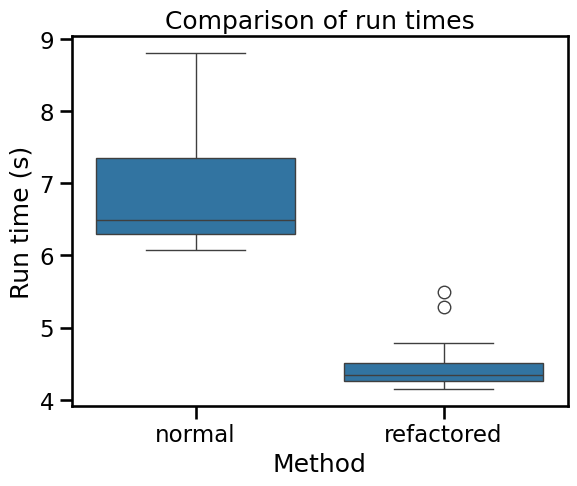

In [60]:
# plot a boxplot to compare times between normal and refactored use seabron
import seaborn as sns
import matplotlib.pyplot as plt

# create dataframe with bith entries
times_df = pd.DataFrame()
times_df["run_time"] = times_normal + times_refactored
times_df["method"] = ["normal"] * 20 + ["refactored"] * 20

# plot the boxplot
sns.boxplot(data=times_df, x="method", y="run_time")
plt.ylabel("Run time (s)")
plt.xlabel("Method")
plt.title("Comparison of run times")

plt.show()

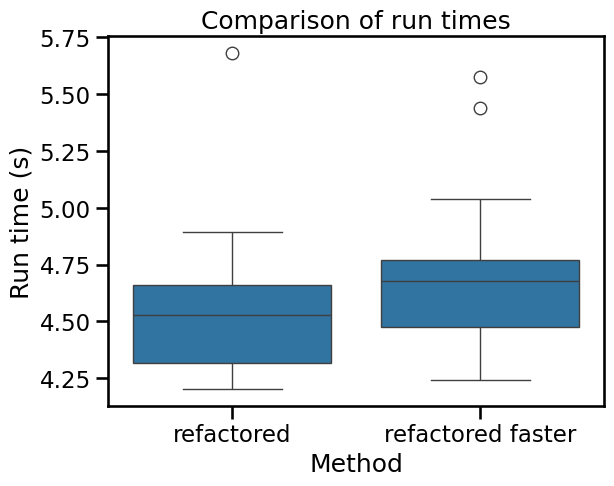

In [69]:
# plot a boxplot to compare times between normal and refactored use seabron
import seaborn as sns
import matplotlib.pyplot as plt

# create dataframe with bith entries
times_df = pd.DataFrame()
times_df["run_time"] = times_normal + times_refactored
times_df["method"] = ["refactored"] * 20 + ["refactored faster"] * 20

# plot the boxplot
sns.boxplot(data=times_df, x="method", y="run_time")
plt.ylabel("Run time (s)")
plt.xlabel("Method")
plt.title("Comparison of run times")

plt.show()

In [5]:
# loop 20 times with tqdm and save the time
from tqdm import tqdm
times_normal = []

print("Setting up model")
model = models.FastVNN(args, snp_ont)

for i in tqdm(range(20), desc="Running normal tests"):

    x = torch.randn(16, 429371, 1)  

    start = time.time()
    aux_out_original, hidden_original = model.forward(x)
    end = time.time()
    times_normal.append(end - start)

Setting up model
Constructing first NN layer
Constructing NN graph


Running normal tests: 100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


In [7]:
np.mean(times_normal)

0.12271919250488281

In [25]:
model.forward(x)

<string>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904035/work/aten/src/ATen/native/TensorShape.cpp:3571.)


({'final_logits': tensor([[-0.0976],
          [ 0.0468],
          [-0.0095],
          ...,
          [-0.1185],
          [-0.1182],
          [-0.0893]], grad_fn=<AddmmBackward0>),
  'final': tensor([[0.4756],
          [0.5117],
          [0.4976],
          ...,
          [0.4704],
          [0.4705],
          [0.4777]], grad_fn=<SigmoidBackward0>)},
 tensor([[-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427],
         [-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427],
         [-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427],
         ...,
         [-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427],
         [-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427],
         [-0.1814, -0.3947, -0.3151,  ..., -0.3307, -0.3285, -0.0427]],
        grad_fn=<SqueezeBackward1>))

In [27]:
from importlib import reload

In [28]:
reload(models)

<module 'src.models' from '/cluster/project/beltrao/gankin/vnn/snp_vnn/src/models.py'>

In [6]:
old_model = models.GenoVNN(args, snp_ont)
# create random data

# Create random gene input data
x = torch.randn(16, 429371, 1)  # For example, a batch of 16 samples

print("Starting speed test")

# Run both the original and refactored versions
# measure time
start = time.time()
aux_out_original, hidden_original = old_model.forward(x)
end = time.time()
print(f"Original forward time: {end - start}")

start = time.time()
aux_out_refactored, hidden_refactored = model.forward(x)
end = time.time()
print(f"Refactored forward time: {end - start}")



computing masks
Constructing first NN layer
Constructing NN graph
Starting speed test
Original forward time: 4.148587465286255
Refactored forward time: 0.09390854835510254


In [ ]:
# Check that the outputs are equal
for term in aux_out_original.keys():
    assert torch.allclose(
        aux_out_original[term], aux_out_refactored[term]
    ), f"Mismatch in aux_out for {term}"
for term in hidden_original.keys():
    assert torch.allclose(
        hidden_original[term][0], hidden_refactored[term][0]
    ), f"Mismatch in hidden state for {term}"

In [8]:
assert aux_out_refactored["final_logits"].shape == aux_out_original["final_logits"].shape
assert aux_out_refactored["final"].shape == aux_out_original["final"].shape